In [1]:
import os.path
from math import gamma

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
%run config.ipynb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

In [2]:
eTraffic = pd.read_csv(os.path.join(root, 'eTraffic_lag0.csv'))
print(eTraffic.shape)
print(len(eTraffic['local_authority_name'].unique()))

(1340, 17)
67


In [3]:
eTraffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   local_authority_name          1340 non-null   object 
 1   year                          1340 non-null   int64  
 2   pedal_cycles                  1340 non-null   float64
 3   two_wheeled_motor_vehicles    1340 non-null   float64
 4   cars_and_taxis                1340 non-null   float64
 5   buses_and_coaches             1340 non-null   float64
 6   LGVs                          1340 non-null   float64
 7   HGVs_2_rigid_axle             1340 non-null   float64
 8   HGVs_3_rigid_axle             1340 non-null   float64
 9   HGVs_4_or_more_rigid_axle     1340 non-null   float64
 10  HGVs_3_or_4_articulated_axle  1340 non-null   float64
 11  HGVs_5_articulated_axle       1340 non-null   float64
 12  HGVs_6_articulated_axle       1340 non-null   float64
 13  all

In [4]:
eTraffic.head()

,local_authority_name,year,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles,GDP,local_authority_name_encoded
0,Barnet,2000,1664.0,16451.0,734298.0,11203.0,129497.0,23104.0,2428.0,3329.0,2593.0,4090.0,3151.0,38695.0,930144.0,64.8,0
1,Barnet,2001,1887.0,17509.0,813092.0,12809.0,143238.0,25830.0,3132.0,3590.0,2794.0,4420.0,3878.0,43644.0,1030292.0,66.5,0
2,Barnet,2002,1328.0,13962.0,732845.0,9997.0,114664.0,21243.0,2853.0,3791.0,1977.0,3934.0,3257.0,37055.0,908523.0,68.5,0
3,Barnet,2003,1712.0,12403.0,617142.0,10739.0,100724.0,14398.0,2222.0,3278.0,1767.0,2666.0,2182.0,26513.0,767521.0,70.1,0
4,Barnet,2004,1443.0,12398.0,576669.0,9097.0,100885.0,15491.0,2760.0,2782.0,1798.0,3425.0,2956.0,29212.0,728261.0,71.4,0


## Select Feature

In [5]:
eTraffic = eTraffic[eTraffic['year'] < 2020]
print(eTraffic['year'].min(), eTraffic['year'].max())
print(eTraffic.shape)

2000 2019
(1340, 17)


In [6]:
X = eTraffic.drop(columns=['GDP', 'year', 'local_authority_name', 'local_authority_name_encoded'])
y = eTraffic['GDP']
print(X.shape, y.shape)

(1340, 13) (1340,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [8]:
param_dist = {
    'n_estimators': np.arange(20, 100, step=5),
    'max_depth': np.arange(3, 12, step=1),
    'min_samples_split': np.arange(3, 12, step=1),
    'min_samples_leaf': np.arange(2, 12, step=1),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=18)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=18)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 11, 'bootstrap': True}
Best score: 0.4968068513710797


In [9]:
# train set
Y_train_hat = random_search.best_estimator_.predict(X_train)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

# test set
Y_test_hat = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

feature_importances = random_search.best_estimator_.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

[RF][Training Set] MSE: 28.33; MAPE: 0.04; MAE: 3.44; R2 score: 0.79
[RF][Testing Set]  MSE: 43.21; MAPE: 0.06; MAE: 5.09; R2 score: 0.65


,Feature,Importance
8,HGVs_3_or_4_articulated_axle,0.226890
10,HGVs_6_articulated_axle,0.183924
5,HGVs_2_rigid_axle,0.181895
4,LGVs,0.079405
7,HGVs_4_or_more_rigid_axle,0.076643
3,buses_and_coaches,0.059444
0,pedal_cycles,0.049439
1,two_wheeled_motor_vehicles,0.048533
9,HGVs_5_articulated_axle,0.028977
6,HGVs_3_rigid_axle,0.027732


### Select features with cumulative importance in the top 90%

In [10]:
features_df['Cumulative Importance'] = features_df['Importance'].cumsum()

selected_features = features_df[features_df['Cumulative Importance'] <= 0.90]['Feature']
print(f"Selected Features number: {len(selected_features)}")
print(f"Selected Features: \n{selected_features}")

Selected Features number: 7
Selected Features: 
8     HGVs_3_or_4_articulated_axle
10         HGVs_6_articulated_axle
5                HGVs_2_rigid_axle
4                             LGVs
7        HGVs_4_or_more_rigid_axle
3                buses_and_coaches
0                     pedal_cycles
Name: Feature, dtype: object


## Retrain the model using selected features
### Random Search parameters

In [11]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(X_train_selected.shape, X_test_selected.shape)
print(X_train_selected.columns)

(1072, 7) (268, 7)
Index(['HGVs_3_or_4_articulated_axle', 'HGVs_6_articulated_axle',
       'HGVs_2_rigid_axle', 'LGVs', 'HGVs_4_or_more_rigid_axle',
       'buses_and_coaches', 'pedal_cycles'],
      dtype='object')


In [12]:
# modeling
param_dist = {
    'n_estimators': np.arange(20, 80, step=5),
    'max_depth': np.arange(3, 10, step=1),
    'min_samples_split': np.arange(3, 10, step=1),
    'min_samples_leaf': np.arange(2, 10, step=1),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=18)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=18)
random_search.fit(X_train_selected, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

rf_best = random_search.best_estimator_

# test set
Y_test_hat = rf_best.predict(X_test_selected)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

# train set
Y_train_hat = rf_best.predict(X_train_selected)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

Best parameters: {'n_estimators': 40, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 9, 'bootstrap': True}
Best score: 0.5033874956575602
[RF][Training Set] MSE: 23.20; MAPE: 0.04; MAE: 3.32; R2 score: 0.83
[RF][Testing Set]  MSE: 44.95; MAPE: 0.06; MAE: 5.11; R2 score: 0.63


### Grid search in a small range base on privous parameters

In [13]:
best_model = random_search.best_params_

param_grid = {
    'n_estimators': [13, 14, 16],
    'max_depth': [5, 8, 11],
    'min_samples_split': [13, 14, 16],
    'min_samples_leaf': [9, 10, 11],
    'bootstrap': [True]
}

rf = RandomForestRegressor(random_state=18)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='r2')
grid_search.fit(X_train_selected, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# train set
Y_train_hat = grid_search.best_estimator_.predict(X_train_selected)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

# test set
Y_test_hat = grid_search.best_estimator_.predict(X_test_selected)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=13; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=14; total time=   0.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=9, min_samples_split=13, n_estimators=14; total time=   0.0s
[CV] END b

In [14]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances.shape)
print(X_train_selected.shape)
features_df = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

(7,)
(1072, 7)


,Feature,Importance
0,HGVs_3_or_4_articulated_axle,0.234696
2,HGVs_2_rigid_axle,0.232455
1,HGVs_6_articulated_axle,0.218785
3,LGVs,0.091981
4,HGVs_4_or_more_rigid_axle,0.087895
5,buses_and_coaches,0.084882
6,pedal_cycles,0.049306


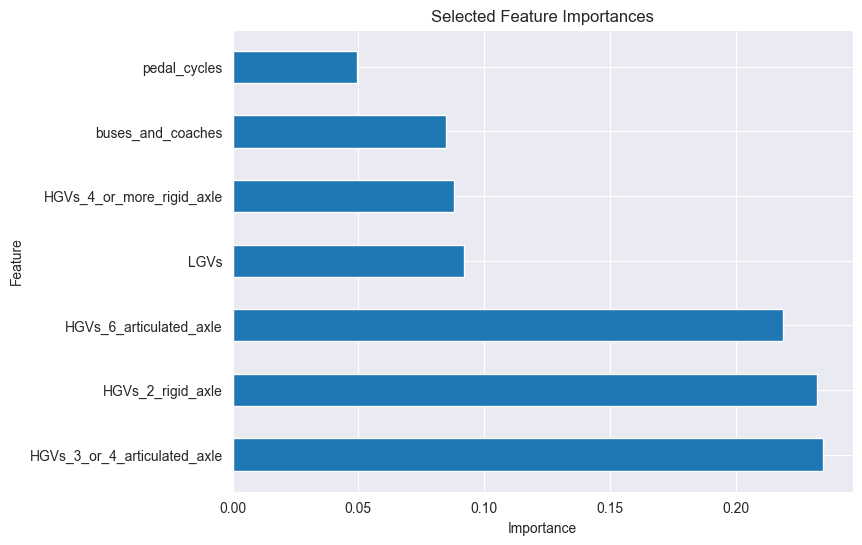

In [15]:
# plot importance of features
plt.figure(figsize=(8, 6))
plt.bar(x=0, bottom=features_df['Feature'],
        height=0.5, width=features_df['Importance'], orientation='horizontal')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Selected Feature Importances')
plt.show()

As we have found the important features:
- HGVs_3_or_4_articulated_axle
- HGVs_6_articulated_axle
- LGVs
- HGVs_2_rigid_axle
- HGVs_4_or_more_rigid_axle
